In [1]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import chess
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# %run ChessBoardEnv.ipynb
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


In [46]:

def get_mapped():
    mapped = {
            'P': 1,     # White Pawn
            'p': -1,    # Black Pawn
            'N': 2,     # White Knight
            'n': -2,    # Black Knight
            'B': 3,     # White Bishop
            'b': -3,    # Black Bishop
            'R': 4,     # White Rook
            'r': -4,    # Black Rook
            'Q': 5,     # White Queen
            'q': -5,    # Black Queen
            'K': 6,     # White King
            'k': -6     # Black King
            }
    return mapped
def get_positions()->np.array:
    letters = ['a','b','c','d','e','f','g','h']
    numbers = [str(num) for num in range(1,9) ]
    promote_piece_letters = ['r','q','b','n']
    positions = []
    second_positions = []
    #all squares
    for letter in letters:
        for number in numbers:
            positions.append(f'{letter}{number}')
            second_positions.append(f'{letter}{number}')
    #squares with promotion
    promotion_numbers = [1,8]
    for letter in letters:
        for number in promotion_numbers:
            for piece_letter in promote_piece_letters:
                second_positions.append(f'{letter}{number}{piece_letter}')
    positions = np.array(positions,dtype=object)
    return positions

class ChessBoardEnv():
    def __init__(self):
        self.black_mapped = {
         #black pieces
        'p': 1,    
        'n': 3,    
        'b': 3,    
        'r': 5,    
        'q': 9
        }
        self.white_mapped = {
            'P':1,
            'N':3,
            'B':3,
            'R':5,
            'Q':9
        }
        self.board = chess.Board()
        self.n_observations = 64
        self.action_space = get_positions()
    
    def get_legal_moves(self)->np.array:
        legal_moves = [str(move) for move in list(self.board.legal_moves)]
        legal_moves = np.array(legal_moves,dtype='object')
        return legal_moves
        
    def sample(self)->list:
        moves_list = self.get_legal_moves()
        choice = np.random.choice(moves_list)
        print(choice)
        from_position = np.where(self.action_space == choice[:2])[0][0]
        to_position = np.where(self.action_space == choice[2:])[0][0]
        return [from_position,to_position]
        
    # def to_uci(self)
    def state(self)->np.array: #this function defines State
        pgn = self.board.epd()
        array = []  #Final board
        pieces = pgn.split(" ", 1)[0]
        rows = pieces.split("/")
        mapped = get_mapped()
        for row in rows:
            array2 = []  #Row
            for thing in row:
                if thing.isdigit():
                    for i in range(0, int(thing)):
                        array2.append(0)
                else:
                    array2.append(mapped[thing])
            array.append(array2)
        return np.array(array,dtype=np.int16).reshape(1,64)

    
    def next_state(self,move_str):
        move = chess.Move.from_uci(move_str)
        if move in self.board.legal_moves:
            self.board.push(move)
        else:
            print("not legal move")
        next_state = self.board.epd()
        self.board.pop()
        return next_state

    def make_move(self,move_str)-> None:
        move = chess.Move.from_uci(move_str)
        if move in self.board.legal_moves:
            self.board.push(move)
        else:
            raise Exception("Illegal move")
        
    
    def calculate_reward_for_move(self):
        color = 'black' if self.board.turn else 'white' # if turn is True(white) then last move was made by black and vice versa
        
        if self.board.is_checkmate():
            if color == 'white':
                return torch.tensor(1.0,device=device, dtype=torch.float32)
            elif color == 'black':
                return torch.tensor(-1.0, device=device, dtype=torch.float32)
        else:
            return torch.tensor(-0.001, device=device, dtype=torch.float32)
        
        if self.board.is_fifty_moves() or self.board.is_stalemate():
            return torch.tensor(-1.0, device=device, dtype=torch.float32)
            
    def reset(self):
        self.board.reset()
        return self.board.fen
        
    def step(self, move_list):
        move_str = f"{self.action_space[move_list[0].item()]}{self.action_space[move_list[1].item()]}"
        self.make_move(move_str)
        reward = self.calculate_reward_for_move()
        turn = 'white' if self.board.turn else 'black'
        observation = self.state()
        terminated = False
        truncated = False
        if self.board.is_checkmate() or self.board.is_stalemate():
            terminated = True
        if self.board.is_fifty_moves():
            truncated = True
        return observation,reward,terminated,truncated




env = ChessBoardEnv()

In [18]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [19]:
class MultiDimLinear(torch.nn.Linear):
    def __init__(self, in_features, out_shape, **kwargs):
        self.out_shape = out_shape
        out_features = np.prod(out_shape)
        super().__init__(in_features, out_features, **kwargs)

    def forward(self, x):
        out = super().forward(x)
        return out.reshape((len(x), *self.out_shape))

In [20]:
class DQN(nn.Module):

    def __init__(self, n_observations):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = MultiDimLinear(in_features=128, out_shape=(2, 64))

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        output = F.softmax(self.layer3(x),dim=2)
        return output


In [21]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [22]:
n_observations = env.n_observations
print(n_observations)

64


In [23]:

policy_net = DQN(n_observations).to(device)
target_net = DQN(n_observations).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [24]:
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

In [25]:
# state = np.random.rand(64)
# state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

# # policy_net(state).max(dim=2).indices.view(2)
# print(env.sample())
# # torch.tensor(env.sample(), device=device, dtype=torch.long)

In [26]:
def select_action(state,board:chess.Board)->list:
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                    math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    move = None
    while move not in board.legal_moves:
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action_tensor =  policy_net(state).max(dim=2).indices.view(2)
                sample = random.random()
                
                
        else:
            print("else")
            return torch.tensor([env.sample()], device=device, dtype=torch.long)
        
        from_position = env.action_space[action_tensor[0]-1]
        to_position = env.action_space[action_tensor[1]-1]
        uci = f'{from_position}{to_position}'
        if from_position != to_position:
            move = chess.Move.from_uci(uci)
        else:
            move = None
    return torch.tensor([[from_position,to_position]], device=device, dtype=torch.long)
    
    
    

episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [27]:
state = env.state() 
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
print(state.shape)


torch.Size([1, 1, 64])


In [28]:

action = select_action(state,env.board)
action
# observation, reward, terminated, truncated = env.step(action)

else


tensor([[33, 35]], device='cuda:0')

In [41]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
        
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    
    optimizer.zero_grad()
    loss.backward()
    
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [47]:

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state = env.state() 
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        action = select_action(state,env.board)
        print("action:",action[0])
        observation, reward, terminated, truncated = env.step(action[0])
        print(reward)
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

else
action: tensor([57, 58], device='cuda:0')
tensor(-0.0010, device='cuda:0')
else
action: tensor([6, 5], device='cuda:0')
tensor(-0.0010, device='cuda:0')
else
action: tensor([ 8, 18], device='cuda:0')
tensor(-0.0010, device='cuda:0')
else
action: tensor([38, 36], device='cuda:0')
tensor(-0.0010, device='cuda:0')
else
action: tensor([58, 59], device='cuda:0')
tensor(-0.0010, device='cuda:0')
else
action: tensor([31, 45], device='cuda:0')
tensor(-0.0010, device='cuda:0')
else
action: tensor([0, 8], device='cuda:0')
tensor(-0.0010, device='cuda:0')
else
action: tensor([55, 38], device='cuda:0')
tensor(-0.0010, device='cuda:0')
else
action: tensor([18, 12], device='cuda:0')
tensor(-0.0010, device='cuda:0')
else
action: tensor([38, 44], device='cuda:0')
tensor(-0.0010, device='cuda:0')
else
action: tensor([1, 3], device='cuda:0')
tensor(-0.0010, device='cuda:0')
else
action: tensor([63, 55], device='cuda:0')
tensor(-0.0010, device='cuda:0')
else
action: tensor([48, 58], device='cuda:0')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [53]:
list(env.board.legal_moves)

[Move.from_uci('g4g6'),
 Move.from_uci('g4g5'),
 Move.from_uci('g4h4'),
 Move.from_uci('g4f4'),
 Move.from_uci('g4e4'),
 Move.from_uci('g4d4'),
 Move.from_uci('g4g3'),
 Move.from_uci('g4g2'),
 Move.from_uci('g4g1'),
 Move.from_uci('c4d5'),
 Move.from_uci('c4b5'),
 Move.from_uci('c4d3'),
 Move.from_uci('c4b3'),
 Move.from_uci('c4e2'),
 Move.from_uci('c4f1'),
 Move.from_uci('d1e1'),
 Move.from_uci('g7g8q'),
 Move.from_uci('g7g8r'),
 Move.from_uci('g7g8b'),
 Move.from_uci('g7g8n'),
 Move.from_uci('f2f3'),
 Move.from_uci('f2f4')]

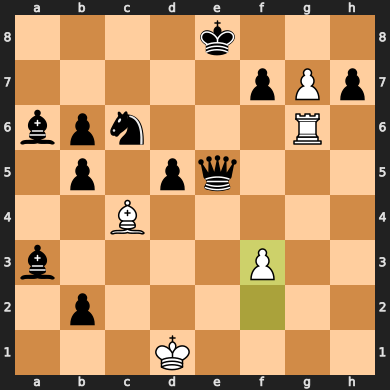

In [60]:
env.board.push_uci('f2f3')
env.board


    

In [61]:
list(env.board.legal_moves)

[Move.from_uci('e8d8'),
 Move.from_uci('e8e7'),
 Move.from_uci('e8d7'),
 Move.from_uci('c6d8'),
 Move.from_uci('c6b8'),
 Move.from_uci('c6e7'),
 Move.from_uci('c6a7'),
 Move.from_uci('c6a5'),
 Move.from_uci('c6d4'),
 Move.from_uci('c6b4'),
 Move.from_uci('a6c8'),
 Move.from_uci('a6b7'),
 Move.from_uci('e5b8'),
 Move.from_uci('e5g7'),
 Move.from_uci('e5e7'),
 Move.from_uci('e5c7'),
 Move.from_uci('e5f6'),
 Move.from_uci('e5e6'),
 Move.from_uci('e5d6'),
 Move.from_uci('e5h5'),
 Move.from_uci('e5g5'),
 Move.from_uci('e5f5'),
 Move.from_uci('e5f4'),
 Move.from_uci('e5e4'),
 Move.from_uci('e5d4'),
 Move.from_uci('e5g3'),
 Move.from_uci('e5e3'),
 Move.from_uci('e5c3'),
 Move.from_uci('e5h2'),
 Move.from_uci('e5e2'),
 Move.from_uci('e5e1'),
 Move.from_uci('a3f8'),
 Move.from_uci('a3e7'),
 Move.from_uci('a3d6'),
 Move.from_uci('a3c5'),
 Move.from_uci('a3b4'),
 Move.from_uci('h7g6'),
 Move.from_uci('f7g6'),
 Move.from_uci('d5c4'),
 Move.from_uci('b5c4'),
 Move.from_uci('h7h6'),
 Move.from_uci('

black


tensor(3.9000)